# Projet 3A

## 1. Tests OpenCV

texte

## 2. Détection d'Horizons

texte

## 3. Extraction de contour des image

Texte

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

Load the image using cv2, by default in bgr format

In [2]:
IMAGE_PATH = '/home/jidoex/Images/Projet3A/cailloux.jpg'

image_bgr = cv2.imread(IMAGE_PATH)

### 3.1 Pre-Segmentation

Shadow removal to help the value channel yield better results

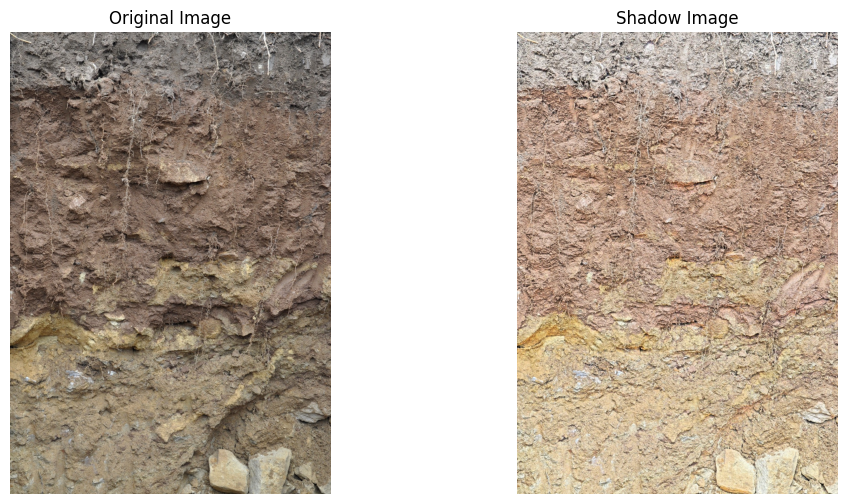

In [3]:
# Conversion to grayscale
gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

# Morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
background = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

# Normalize image to remove shadows
shadow_free = cv2.divide(gray, background, scale=255)

# Temporary HSV conversion
temp_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
temp_hsv[:,:,2] = shadow_free

# Back to BGR
no_shadow_bgr = cv2.cvtColor(temp_hsv, cv2.COLOR_HSV2BGR)

# Shadow results
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(no_shadow_bgr, cv2.COLOR_BGR2RGB))
plt.title('Shadow Image')
plt.axis('off')

plt.show()

The Gaussian filter was used to “fuzzy” the image, to highlight the targets, to restrain detailed information, such as noise in the image, and to improve the accuracy of segmentation for the next step.

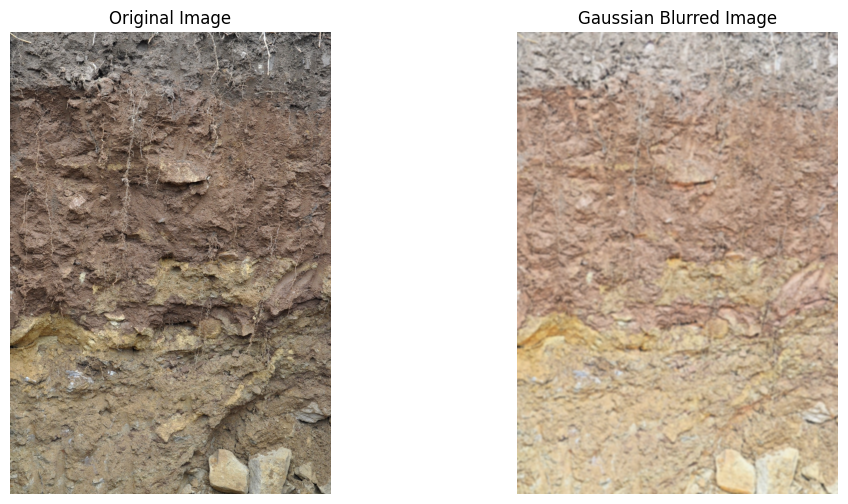

In [4]:
# Will have to fiddle around with the kernel of the Gaussian blur

smoothed_bgr = cv2.GaussianBlur(no_shadow_bgr, (19, 19), 0)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(smoothed_bgr, cv2.COLOR_BGR2RGB))
plt.title('Gaussian Blurred Image')
plt.axis('off')

plt.show()

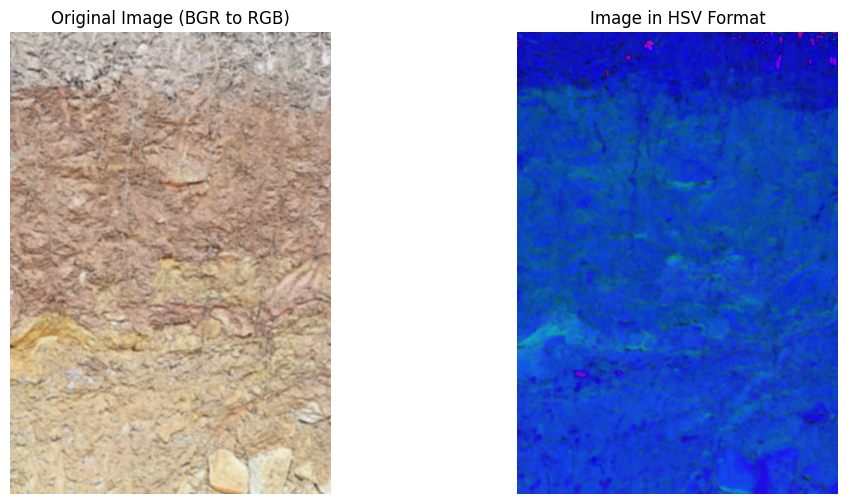

In [5]:
# Conversion vers HSV
image_hsv = cv2.cvtColor(smoothed_bgr, cv2.COLOR_BGR2HSV)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(smoothed_bgr, cv2.COLOR_BGR2RGB))
plt.title('Original Image (BGR to RGB)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_hsv)  # HSV visualization
plt.title('Image in HSV Format')
plt.axis('off')

plt.show()

Separate the Hue, Saturation and Value channels

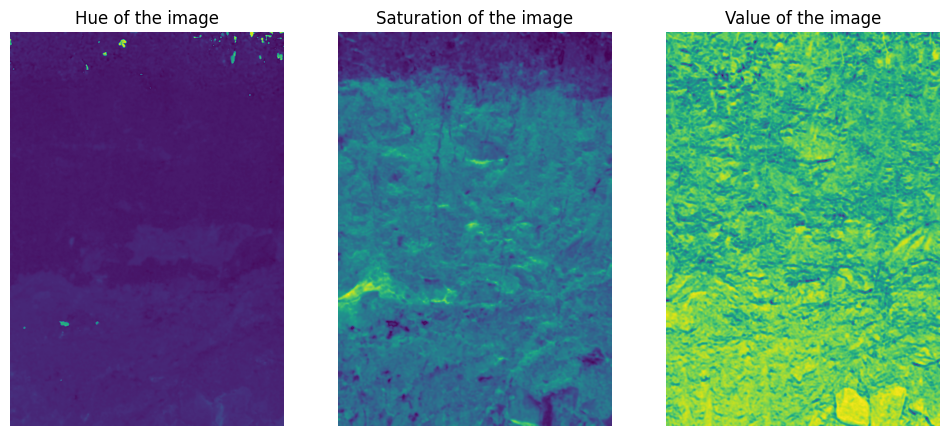

In [6]:
image_h, image_s, image_v = cv2.split(image_hsv)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(image_h)
plt.title('Hue of the image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_s)
plt.title('Saturation of the image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_v)
plt.title('Value of the image')
plt.axis('off')

plt.show()

The maximum filter was used to enhance the contrast between small particle-size objects and the soil matrix in the S channel.

In [7]:
# TODO

### 3.2 Segmentation

Sobel filter (Sobel, 1990)

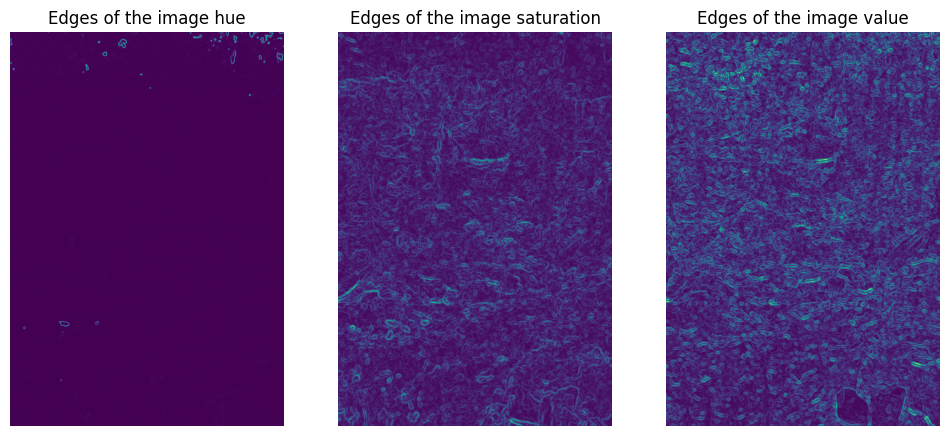

In [8]:
# Sobel filter hue
sobel_h_x = cv2.Sobel(image_h, cv2.CV_64F, 1, 0, ksize=3)
sobel_h_y = cv2.Sobel(image_h, cv2.CV_64F, 0, 1, ksize=3)
edges_h = cv2.magnitude(sobel_h_x, sobel_h_y)

# Sobel filter saturation
sobel_s_x = cv2.Sobel(image_s, cv2.CV_64F, 1, 0, ksize=3)
sobel_s_y = cv2.Sobel(image_s, cv2.CV_64F, 0, 1, ksize=3)
edges_s = cv2.magnitude(sobel_s_x, sobel_s_y)

# Sobel filter value
sobel_v_x = cv2.Sobel(image_v, cv2.CV_64F, 1, 0, ksize=3)
sobel_v_y = cv2.Sobel(image_v, cv2.CV_64F, 0, 1, ksize=3)
edges_v = cv2.magnitude(sobel_v_x, sobel_v_y)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(edges_h)
plt.title('Edges of the image hue')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(edges_s)
plt.title('Edges of the image saturation')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(edges_v)
plt.title('Edges of the image value')
plt.axis('off')

plt.show()

In [9]:
# Threshold to define watershed

# For hue
_, markers_h = cv2.threshold(edges_h, 50, 255, cv2.THRESH_BINARY)
markers_h = cv2.connectedComponents(np.uint8(markers_h))[1]

# For saturation
_, markers_s = cv2.threshold(edges_s, 50, 255, cv2.THRESH_BINARY)
markers_s = cv2.connectedComponents(np.uint8(markers_s))[1]

# For value
_, markers_v = cv2.threshold(edges_v, 50, 255, cv2.THRESH_BINARY)
markers_v = cv2.connectedComponents(np.uint8(markers_v))[1]

Region growing watershed algorithm

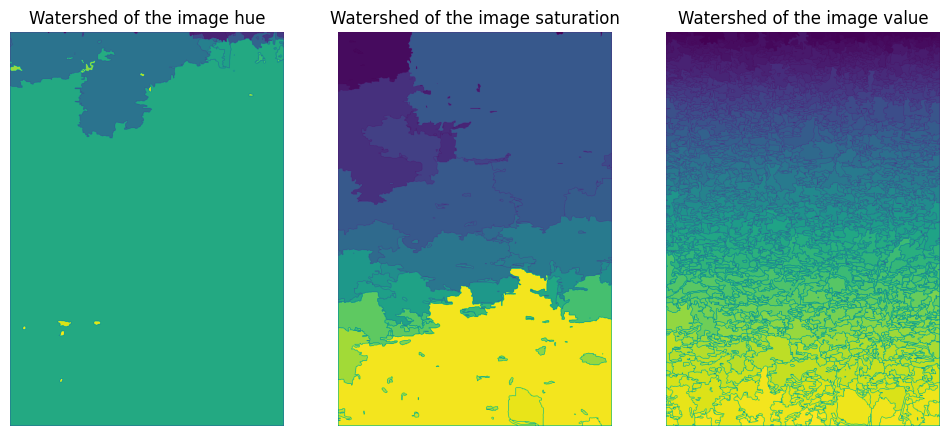

In [16]:
markers_h = cv2.watershed(no_shadow_bgr, markers_h)
markers_s = cv2.watershed(no_shadow_bgr, markers_s)
markers_v = cv2.watershed(no_shadow_bgr, markers_v)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(markers_h)
plt.title('Watershed of the image hue')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(markers_s)
plt.title('Watershed of the image saturation')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(markers_v)
plt.title('Watershed of the image value')
plt.axis('off')

plt.show()

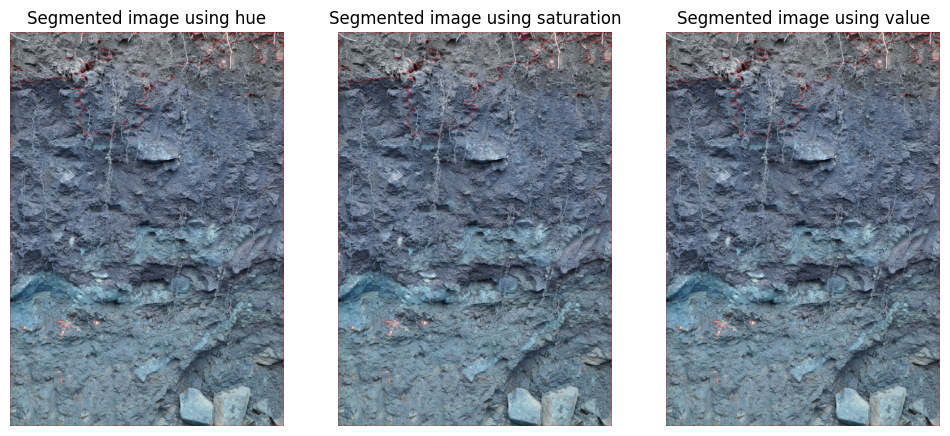

In [17]:
segmented_image_h = np.copy(image_bgr)
segmented_image_h[markers_h == -1] = [255, 0, 0]

segmented_image_s = np.copy(image_bgr)
segmented_image_s[markers_s == -1] = [255, 0, 0]

segmented_image_v = np.copy(image_bgr)
segmented_image_v[markers_v == -1] = [255, 0, 0]

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(segmented_image_h)
plt.title('Segmented image using hue')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(segmented_image_h)
plt.title('Segmented image using saturation')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image_h)
plt.title('Segmented image using value')
plt.axis('off')

plt.show()

### 3.3 Post-processing

In [12]:
binary_mask = (markers_v > 0).astype(np.uint8)

print(f"Rock Fragment Concentration: {rf_concentration:.2f}%")

# Display the results
#cv2.imshow("Segmented Image", segmented_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

Rock Fragment Concentration: 90.96%
